In [1]:
# %%
%load_ext autoreload
%autoreload 2

# %%
import os
import sys
sys.path.append("/n/home12/binxuwang/Github/Closed-loop-visual-insilico")
import torch
import torch as th
import torch.nn as nn
from tqdm.auto import tqdm
from os.path import join
import pickle as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from circuit_toolkit.plot_utils import to_imgrid, show_imgrid, save_imgrid, saveallforms
from circuit_toolkit.layer_hook_utils import featureFetcher_module, featureFetcher, get_module_names
from circuit_toolkit.dataset_utils import ImagePathDataset
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
# %%
import sys
sys.path.append("/n/home12/binxuwang/Github/Closed-loop-visual-insilico")
from core.model_load_utils import load_model_transform, MODEL_LAYER_FILTERS, LAYER_ABBREVIATION_MAPS
from neural_regress.feature_reduction_lib import FEATURE_REDUCTION_DEFAULTS, LAYER_TRANSFORM_FILTERS
from neural_regress.regress_lib import record_features, perform_regression_sweeplayer, perform_regression_sweeplayer_RidgeCV
from neural_regress.regress_lib import sweep_regressors, transform_features2Xdict_new, transform_features2Xdict, RidgeCV, apply_feature_transforms
from neural_regress.regress_eval_lib import format_result_df, plot_result_df_per_layer, construct_result_df_masked, \
    compute_pred_dict_D2_per_unit
from neural_regress.regress_lib import sweep_regressors
from neural_regress.sklearn_torchify_lib import SRP_torch, PCA_torch, LinearRegression_torch, SpatialAvg_torch
from core.data_utils import load_from_hdf5, load_neural_data, load_neural_trial_resp_tensor, create_response_tensor, parse_image_fullpaths, extract_neural_data_dict_2025apr
#%% Utility Functions

In [ ]:
!cp /n/home12/binxuwang/Github/Closed-loop-visual-insilico/notebooks/encoding_stimuli_split_seed0_swapped.csv {encoding_stim_dir}

In [2]:
dataroot = r"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Ephys_Data"
encoding_stim_dir = r"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Stimuli/encodingstimuli_apr2025"
outputroot = r"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_models"
output_subdir_name = "model_outputs_trials_denoising_features"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
# load the train/test split
# df_stim = pd.read_csv(join(encoding_stim_dir, "encoding_stimuli_split_seed0.csv"), )
df_stim = pd.read_csv(join(encoding_stim_dir, "encoding_stimuli_split_seed0_swapped.csv"), )
train_idx = df_stim[df_stim["is_train"]].index

Using device: cuda


In [ ]:

for subject_id, filename in [
    # ("red_20250428-20240429", "red_20250428-20240429_vvs-encodingstimuli_z1_rw100-400.h5"),
    ("red_20250428-20250430", "red_20250428-20250430_vvs-encodingstimuli_z1_rw100-400.h5"), 
    # ("paul_20250428-20250430", "paul_20250428-20250430_vvs-encodingstimuli_z1_rw100-400.h5"), 
    # ("venus_250426-250429", "venus_250426-250429_vvs-encodingstimuli_z1_rw80-250.h5"),
    # ("three0_250426-250501", "three0_250426-250501_vvs-encodingstimuli_z1_rw80-250.h5"),
    # ("leap_250426-250501", "leap_250426-250501_vvs-encodingstimuli_z1_rw80-250.h5"),
    # ("three0_250426-250430", "three0_250426-250430_vvs-encodingstimuli_z1_rw80-250.h5"), 
     
]:
    print(subject_id)
    data_path = join(dataroot, filename)
    data = load_from_hdf5(data_path)
    print(list(data))
    data_dict = extract_neural_data_dict_2025apr(data)
    data_dict['image_fps'] = parse_image_fullpaths(data_dict["stimulus_names"], [encoding_stim_dir], arbitrary_format=True)
    image_fps = data_dict['image_fps']
    resp_mat = data_dict['resp_mat']
    reliability = data_dict['reliability']
    ncsnr = data_dict['ncsnr']

    figdir = join(outputroot, subject_id, output_subdir_name)
    os.makedirs(figdir, exist_ok=True)
    
    resp_tensor, trial_counters = create_response_tensor(data['trials']['stimulus_name'], data['trials']['response_peak'], data['repavg']['stimulus_name'])
    trial_resp_dict = {
        "resp_tensor": resp_tensor,
        "trial_counters": trial_counters,
        "stimulus_names": data['repavg']['stimulus_name'],
    }
    pkl.dump(trial_resp_dict, open(join(figdir, f"{subject_id}_trial_resp_tsr_dict.pkl"), "wb"))

    batch_size = 96

    model_names = [
        "resnet50",
        "resnet50_robust",
        "resnet50_clip",
        "resnet50_dino",
        "regnety_640",
        "dinov2_vitb14_reg",
        "clipag_vitb32",
        "siglip2_vitb16",
        "radio_v2.5-b",
        "AlexNet_training_seed_01",
        # "ReAlnet01",
    ]

    for modelname in model_names:
        print(f"\nTesting model: {modelname}")
        try:
            # Load model and transforms
            model, transforms_pipeline = load_model_transform(modelname, device)
        except Exception as e:  
            print(f"Error loading model {modelname}: {str(e)}")
            continue
        print(f"Successfully loaded model: {modelname}")
        dataset = ImagePathDataset(image_fps, scores=None, transform=transforms_pipeline)
        print(f"Successfully created dataset for {modelname} with {len(dataset)} images")
        # Create feature fetcher
        fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
        print(f"Successfully created feature fetcher for {modelname}")
        # Get all module names
        all_module_names = list(fetcher.module_names.values())
        print(f"Total number of modules: {len(all_module_names)}")
        # Get layer filter for this model
        layer_filter = MODEL_LAYER_FILTERS[modelname]
        layer_abbrev = LAYER_ABBREVIATION_MAPS[modelname]
        # Count layers that pass the filter
        module_names2record = [name for name in all_module_names if layer_filter(name)]
        print(f"Number of layers passing filter: {len(module_names2record)}")
        print(f"Filtered layer names: {module_names2record}")
        module_names2record_abbrev = [layer_abbrev(name) for name in module_names2record]
        print(f"Filtered layer names (abbreviated): {module_names2record_abbrev}")
        # # hook the layers
        for name in module_names2record: 
            fetcher.record(name, store_device='cpu', ingraph=False, )
        
        # Record features
        feat_dict_lyrswp = record_features(model, fetcher, dataset, batch_size=batch_size, device=device)
        # Cleanup
        print(f"{modelname} done!!!")
        
        fetcher.cleanup()
        
        dimred_list = ["pca750", ]
        # for all models do PCA and SRP
        Xdict_lyrswp, Xtfmer_lyrswp = transform_features2Xdict_new(feat_dict_lyrswp, module_names2record, 
                            dimred_list=dimred_list, pretrained_Xtransforms={}, #  "srp"
                            use_pca_dual=True, use_srp_torch=True, train_split_idx=train_idx)
        
        if modelname in FEATURE_REDUCTION_DEFAULTS and not ("resnet" in modelname):
            # ViT models using the default feature reduction, pretrained feature reduction
            dimred_transform_dict = FEATURE_REDUCTION_DEFAULTS[modelname](model)
            layer_transform_filter = LAYER_TRANSFORM_FILTERS[modelname]
            dimred_list = dimred_list + list(dimred_transform_dict.keys())
            # apply the feature reduction to the layers
            Xdict_lyrswp_cls, Xtfmer_lyrswp_cls = apply_feature_transforms(
                feat_dict_lyrswp, module_names2record, dimred_transform_dict, layer_transform_filter)
            # merge the two dictionaries to Xdict_lyrswp and Xtfmer_lyrswp
            Xdict_lyrswp.update(Xdict_lyrswp_cls)
            Xtfmer_lyrswp.update(Xtfmer_lyrswp_cls)
        
        print(f"Applied feature reduction: {dimred_list}")
        print(f"{len(Xdict_lyrswp)} features computed! ")
        
        resp_mat_sel = resp_mat[:, :] # Select all channels, no mask
        print(f"Fitting models for All channels N={resp_mat_sel.shape[1]}")
        regressors = [RidgeCV(alphas=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9], 
                            alpha_per_target=True,),
                    # MultiTaskLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
                    # MultiOutputSeparateLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
                    ] 
        regressor_names = ["RidgeCV"]
        print(f"Sweeping regressors: {regressor_names}")
        result_df_lyrswp, fit_models_lyrswp = sweep_regressors(Xdict_lyrswp, resp_mat_sel, regressors, regressor_names, 
                                                            verbose=True, train_split_idx=train_idx)
        pred_D2_dict = compute_pred_dict_D2_per_unit(fit_models_lyrswp, Xdict_lyrswp, resp_mat_sel, idx_train=train_idx) # Fixed the bug! now the train/test split is fixed
    
        result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV_formatted.csv"))
        figh = plot_result_df_per_layer(result_df_lyrswp, dimred_list=dimred_list, shorten_func=layer_abbrev, sharey=True, grid=True)
        figh.suptitle(f"{subject_id} {modelname} layer sweep")
        figh.tight_layout()
        figh.show()
        saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis", figh=figh)
        # Get the key with best test score
        best_key = result_df_lyrswp['test_score'].idxmax()
        print(f"Best performing layer: {best_key}")
        print(f"Test score: {result_df_lyrswp.loc[best_key, 'test_score'].item():.3f}")
        best_key_layer = best_key[0]
        Xdict_prune = {}
        Xdict_prune["features"] = Xdict_lyrswp[best_key_layer]
        Xdict_prune["regressor"] = best_key[1]
        Xdict_prune["dimred"] = best_key_layer[1]
        Xdict_prune["layer"] = best_key_layer[0]
        Xdict_prune["model"] = modelname
        Xdict_prune["subject"] = subject_id
        pkl.dump(Xdict_prune, open(join(figdir, f"{subject_id}_{modelname}_population_best_layer_Xfeatures.pkl"), "wb"))
        plt.close("all")
        
        # raise Exception("Stop here")
        
        # # pkl.dump(pred_D2_dict, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "wb"))
        # # result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV.csv"))
        # # result_df_lyrswp.to_pickle(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV_df.pkl"))
        # # th.save(fit_models_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_fitmodels_RidgeCV.pth")) 
        # # th.save(Xtfmer_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pth"))
        # # pkl.dump(Xtfmer_lyrswp, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"), "wb"))
        # # %%
        # result_df_lyrswp = format_result_df(result_df_lyrswp, dimred_list)
        # result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV_formatted.csv"))
        # figh = plot_result_df_per_layer(result_df_lyrswp, dimred_list=dimred_list, shorten_func=layer_abbrev, sharey=True, grid=True)
        # figh.suptitle(f"{subject_id} {modelname} layer sweep")
        # figh.tight_layout()
        # figh.show()
        # saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis", figh=figh)
        # # %%
        # # Mask out unreliable channels and plot again
        # for thresh in [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]:
        #     channel_count = (reliability > thresh).sum()
        #     result_df_masked = construct_result_df_masked(pred_D2_dict['D2_per_unit_train_dict'], 
        #                                                 pred_D2_dict['D2_per_unit_test_dict'], 
        #                                                 mask=reliability > thresh)
        #     figh = plot_result_df_per_layer(result_df_masked, dimred_list=dimred_list, shorten_func=layer_abbrev, sharey=True, grid=True)
        #     figh.suptitle(f"{subject_id} {modelname} layer sweep | reliable channels > {thresh} (N={channel_count})")
        #     figh.tight_layout()
        #     figh.show()
        #     saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis_reliable_thresh{thresh}_masked", figh=figh)
        
        # topk_reliable_chan_idx = np.argsort(reliability)[-5:][::-1]
        # topk_reliable = reliability[topk_reliable_chan_idx]
        # print("Top 5 most reliability: ", topk_reliable)
        # print("Top 5 most reliable channels idx: ", topk_reliable_chan_idx)
        # for idx in topk_reliable_chan_idx:
        #     single_chan_result_df = construct_result_df_masked(pred_D2_dict['D2_per_unit_train_dict'], 
        #                                                     pred_D2_dict['D2_per_unit_test_dict'], 
        #                                                     mask=idx)
        #     figh = plot_result_df_per_layer(single_chan_result_df, dimred_list=dimred_list, shorten_func=layer_abbrev, sharey=True, grid=True)
        #     figh.suptitle(f"{subject_id} {modelname} layer sweep | Top reliable channel {idx} | reliability: {reliability[idx]:.3f}")
        #     figh.tight_layout()
        #     figh.show()
        #     saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis_single_reliable_Ch{idx:02d}", figh=figh)
        
        # plt.close("all")
        # if "resnet50" in modelname:
        #     # if so, save the sparsified Xtfmer_lyrswp, not every layer 
        #     Xtfmer_lyrswp_sparse = {k: v for k, v in Xtfmer_lyrswp.items() if ("layer4" in k or "layer4" in k[0])  and "pca" in k}
        #     th.save(Xtfmer_lyrswp_sparse, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pth"))
        # try:
        #     pkl.dump(Xtfmer_lyrswp, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"), "wb"))
        # except:
        #     pass
    

red_20250428-20250430
['README', 'neuron_metadata', 'repavg', 'stimulus_meta', 'trials']
All stimulus files were found
Response tensor shape (stimulus x neuron x trial): (969, 64, 10)

Testing model: resnet50


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Successfully loaded model: resnet50
The (227, 227) setting is overwritten by the size in custom transform
Successfully created dataset for resnet50 with 969 images
Successfully created feature fetcher for resnet50
Total number of modules: 184
Number of layers passing filter: 16
Filtered layer names: ['.layer1.Bottleneck0', '.layer1.Bottleneck1', '.layer1.Bottleneck2', '.layer2.Bottleneck0', '.layer2.Bottleneck1', '.layer2.Bottleneck2', '.layer2.Bottleneck3', '.layer3.Bottleneck0', '.layer3.Bottleneck1', '.layer3.Bottleneck2', '.layer3.Bottleneck3', '.layer3.Bottleneck4', '.layer3.Bottleneck5', '.layer4.Bottleneck0', '.layer4.Bottleneck1', '.layer4.Bottleneck2']
Filtered layer names (abbreviated): ['L1.B0', 'L1.B1', 'L1.B2', 'L2.B0', 'L2.B1', 'L2.B2', 'L2.B3', 'L3.B0', 'L3.B1', 'L3.B2', 'L3.B3', 'L3.B4', 'L3.B5', 'L4.B0', 'L4.B1', 'L4.B2']


  0%|          | 0/11 [00:00<?, ?it/s]

.layer1.Bottleneck0 torch.Size([969, 256, 56, 56])
.layer1.Bottleneck1 torch.Size([969, 256, 56, 56])
.layer1.Bottleneck2 torch.Size([969, 256, 56, 56])
.layer2.Bottleneck0 torch.Size([969, 512, 28, 28])
.layer2.Bottleneck1 torch.Size([969, 512, 28, 28])
.layer2.Bottleneck2 torch.Size([969, 512, 28, 28])
.layer2.Bottleneck3 torch.Size([969, 512, 28, 28])
.layer3.Bottleneck0 torch.Size([969, 1024, 14, 14])
.layer3.Bottleneck1 torch.Size([969, 1024, 14, 14])
.layer3.Bottleneck2 torch.Size([969, 1024, 14, 14])
.layer3.Bottleneck3 torch.Size([969, 1024, 14, 14])
.layer3.Bottleneck4 torch.Size([969, 1024, 14, 14])
.layer3.Bottleneck5 torch.Size([969, 1024, 14, 14])
.layer4.Bottleneck0 torch.Size([969, 2048, 7, 7])
.layer4.Bottleneck1 torch.Size([969, 2048, 7, 7])
.layer4.Bottleneck2 torch.Size([969, 2048, 7, 7])
resnet50 done!!!
FeatureFetcher hooks all freed
.layer1.Bottleneck0 torch.Size([969, 256, 56, 56])
Time taken to transform .layer1.Bottleneck0 pca750 [969, 750]: 2.525s
Time taken t

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Successfully loaded model: resnet50_robust
The (227, 227) setting is overwritten by the size in custom transform
Successfully created dataset for resnet50_robust with 969 images
Successfully created feature fetcher for resnet50_robust
Total number of modules: 184
Number of layers passing filter: 16
Filtered layer names: ['.layer1.Bottleneck0', '.layer1.Bottleneck1', '.layer1.Bottleneck2', '.layer2.Bottleneck0', '.layer2.Bottleneck1', '.layer2.Bottleneck2', '.layer2.Bottleneck3', '.layer3.Bottleneck0', '.layer3.Bottleneck1', '.layer3.Bottleneck2', '.layer3.Bottleneck3', '.layer3.Bottleneck4', '.layer3.Bottleneck5', '.layer4.Bottleneck0', '.layer4.Bottleneck1', '.layer4.Bottleneck2']
Filtered layer names (abbreviated): ['L1.B0', 'L1.B1', 'L1.B2', 'L2.B0', 'L2.B1', 'L2.B2', 'L2.B3', 'L3.B0', 'L3.B1', 'L3.B2', 'L3.B3', 'L3.B4', 'L3.B5', 'L4.B0', 'L4.B1', 'L4.B2']


  0%|          | 0/11 [00:00<?, ?it/s]

.layer1.Bottleneck0 torch.Size([969, 256, 56, 56])
.layer1.Bottleneck1 torch.Size([969, 256, 56, 56])
.layer1.Bottleneck2 torch.Size([969, 256, 56, 56])
.layer2.Bottleneck0 torch.Size([969, 512, 28, 28])
.layer2.Bottleneck1 torch.Size([969, 512, 28, 28])
.layer2.Bottleneck2 torch.Size([969, 512, 28, 28])
.layer2.Bottleneck3 torch.Size([969, 512, 28, 28])
.layer3.Bottleneck0 torch.Size([969, 1024, 14, 14])
.layer3.Bottleneck1 torch.Size([969, 1024, 14, 14])
.layer3.Bottleneck2 torch.Size([969, 1024, 14, 14])
.layer3.Bottleneck3 torch.Size([969, 1024, 14, 14])
.layer3.Bottleneck4 torch.Size([969, 1024, 14, 14])
.layer3.Bottleneck5 torch.Size([969, 1024, 14, 14])
.layer4.Bottleneck0 torch.Size([969, 2048, 7, 7])
.layer4.Bottleneck1 torch.Size([969, 2048, 7, 7])
.layer4.Bottleneck2 torch.Size([969, 2048, 7, 7])
resnet50_robust done!!!
FeatureFetcher hooks all freed
.layer1.Bottleneck0 torch.Size([969, 256, 56, 56])
Time taken to transform .layer1.Bottleneck0 pca750 [969, 750]: 2.533s
Time 

  0%|          | 0/11 [00:00<?, ?it/s]

.layer1.Bottleneck0 torch.Size([969, 256, 56, 56])
.layer1.Bottleneck1 torch.Size([969, 256, 56, 56])
.layer1.Bottleneck2 torch.Size([969, 256, 56, 56])
.layer2.Bottleneck0 torch.Size([969, 512, 28, 28])
.layer2.Bottleneck1 torch.Size([969, 512, 28, 28])
.layer2.Bottleneck2 torch.Size([969, 512, 28, 28])
.layer2.Bottleneck3 torch.Size([969, 512, 28, 28])
.layer3.Bottleneck0 torch.Size([969, 1024, 14, 14])
.layer3.Bottleneck1 torch.Size([969, 1024, 14, 14])
.layer3.Bottleneck2 torch.Size([969, 1024, 14, 14])
.layer3.Bottleneck3 torch.Size([969, 1024, 14, 14])
.layer3.Bottleneck4 torch.Size([969, 1024, 14, 14])
.layer3.Bottleneck5 torch.Size([969, 1024, 14, 14])
.layer4.Bottleneck0 torch.Size([969, 2048, 7, 7])
.layer4.Bottleneck1 torch.Size([969, 2048, 7, 7])
.layer4.Bottleneck2 torch.Size([969, 2048, 7, 7])
resnet50_clip done!!!
FeatureFetcher hooks all freed
.layer1.Bottleneck0 torch.Size([969, 256, 56, 56])
Time taken to transform .layer1.Bottleneck0 pca750 [969, 750]: 3.069s
Time ta

Using cache found in /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/facebookresearch_dino_main
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Successfully loaded model: resnet50_dino
The (227, 227) setting is overwritten by the size in custom transform
Successfully created dataset for resnet50_dino with 969 images
Successfully created feature fetcher for resnet50_dino
Total number of modules: 184
Number of layers passing filter: 16
Filtered layer names: ['.layer1.Bottleneck0', '.layer1.Bottleneck1', '.layer1.Bottleneck2', '.layer2.Bottleneck0', '.layer2.Bottleneck1', '.layer2.Bottleneck2', '.layer2.Bottleneck3', '.layer3.Bottleneck0', '.layer3.Bottleneck1', '.layer3.Bottleneck2', '.layer3.Bottleneck3', '.layer3.Bottleneck4', '.layer3.Bottleneck5', '.layer4.Bottleneck0', '.layer4.Bottleneck1', '.layer4.Bottleneck2']
Filtered layer names (abbreviated): ['L1.B0', 'L1.B1', 'L1.B2', 'L2.B0', 'L2.B1', 'L2.B2', 'L2.B3', 'L3.B0', 'L3.B1', 'L3.B2', 'L3.B3', 'L3.B4', 'L3.B5', 'L4.B0', 'L4.B1', 'L4.B2']


  0%|          | 0/11 [00:00<?, ?it/s]

.layer1.Bottleneck0 torch.Size([969, 256, 56, 56])
.layer1.Bottleneck1 torch.Size([969, 256, 56, 56])
.layer1.Bottleneck2 torch.Size([969, 256, 56, 56])
.layer2.Bottleneck0 torch.Size([969, 512, 28, 28])
.layer2.Bottleneck1 torch.Size([969, 512, 28, 28])
.layer2.Bottleneck2 torch.Size([969, 512, 28, 28])
.layer2.Bottleneck3 torch.Size([969, 512, 28, 28])
.layer3.Bottleneck0 torch.Size([969, 1024, 14, 14])
.layer3.Bottleneck1 torch.Size([969, 1024, 14, 14])
.layer3.Bottleneck2 torch.Size([969, 1024, 14, 14])
.layer3.Bottleneck3 torch.Size([969, 1024, 14, 14])
.layer3.Bottleneck4 torch.Size([969, 1024, 14, 14])
.layer3.Bottleneck5 torch.Size([969, 1024, 14, 14])
.layer4.Bottleneck0 torch.Size([969, 2048, 7, 7])
.layer4.Bottleneck1 torch.Size([969, 2048, 7, 7])
.layer4.Bottleneck2 torch.Size([969, 2048, 7, 7])
resnet50_dino done!!!
FeatureFetcher hooks all freed
.layer1.Bottleneck0 torch.Size([969, 256, 56, 56])
Time taken to transform .layer1.Bottleneck0 pca750 [969, 750]: 2.603s
Time ta

  0%|          | 0/11 [00:00<?, ?it/s]

.s1.Bottleneckb1 torch.Size([969, 328, 56, 56])
.s1.Bottleneckb2 torch.Size([969, 328, 56, 56])
.s2.Bottleneckb1 torch.Size([969, 984, 28, 28])
.s2.Bottleneckb2 torch.Size([969, 984, 28, 28])
.s2.Bottleneckb3 torch.Size([969, 984, 28, 28])
.s2.Bottleneckb4 torch.Size([969, 984, 28, 28])
.s2.Bottleneckb5 torch.Size([969, 984, 28, 28])
.s3.Bottleneckb1 torch.Size([969, 1968, 14, 14])
.s3.Bottleneckb2 torch.Size([969, 1968, 14, 14])
.s3.Bottleneckb3 torch.Size([969, 1968, 14, 14])
.s3.Bottleneckb4 torch.Size([969, 1968, 14, 14])
.s3.Bottleneckb5 torch.Size([969, 1968, 14, 14])
.s3.Bottleneckb6 torch.Size([969, 1968, 14, 14])
.s3.Bottleneckb7 torch.Size([969, 1968, 14, 14])
.s3.Bottleneckb8 torch.Size([969, 1968, 14, 14])
.s3.Bottleneckb9 torch.Size([969, 1968, 14, 14])
.s3.Bottleneckb10 torch.Size([969, 1968, 14, 14])
.s3.Bottleneckb11 torch.Size([969, 1968, 14, 14])
.s3.Bottleneckb12 torch.Size([969, 1968, 14, 14])
.s4.Bottleneckb1 torch.Size([969, 4920, 7, 7])
regnety_640 done!!!
Featur

Using cache found in /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/facebookresearch_dinov2_main
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


Successfully loaded model: dinov2_vitb14_reg
The (227, 227) setting is overwritten by the size in custom transform
Successfully created dataset for dinov2_vitb14_reg with 969 images
Successfully created feature fetcher for dinov2_vitb14_reg
Total number of modules: 187
Number of layers passing filter: 12
Filtered layer names: ['.blocks.NestedTensorBlock0', '.blocks.NestedTensorBlock1', '.blocks.NestedTensorBlock2', '.blocks.NestedTensorBlock3', '.blocks.NestedTensorBlock4', '.blocks.NestedTensorBlock5', '.blocks.NestedTensorBlock6', '.blocks.NestedTensorBlock7', '.blocks.NestedTensorBlock8', '.blocks.NestedTensorBlock9', '.blocks.NestedTensorBlock10', '.blocks.NestedTensorBlock11']
Filtered layer names (abbreviated): ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11']


  0%|          | 0/11 [00:00<?, ?it/s]

.blocks.NestedTensorBlock0 torch.Size([969, 261, 768])
.blocks.NestedTensorBlock1 torch.Size([969, 261, 768])
.blocks.NestedTensorBlock2 torch.Size([969, 261, 768])
.blocks.NestedTensorBlock3 torch.Size([969, 261, 768])
.blocks.NestedTensorBlock4 torch.Size([969, 261, 768])
.blocks.NestedTensorBlock5 torch.Size([969, 261, 768])
.blocks.NestedTensorBlock6 torch.Size([969, 261, 768])
.blocks.NestedTensorBlock7 torch.Size([969, 261, 768])
.blocks.NestedTensorBlock8 torch.Size([969, 261, 768])
.blocks.NestedTensorBlock9 torch.Size([969, 261, 768])
.blocks.NestedTensorBlock10 torch.Size([969, 261, 768])
.blocks.NestedTensorBlock11 torch.Size([969, 261, 768])
dinov2_vitb14_reg done!!!
FeatureFetcher hooks all freed
.blocks.NestedTensorBlock0 torch.Size([969, 261, 768])
Time taken to transform .blocks.NestedTensorBlock0 pca750 [969, 750]: 0.630s
Time taken to transform .blocks.NestedTensorBlock0: 0.794s
.blocks.NestedTensorBlock1 torch.Size([969, 261, 768])
Time taken to transform .blocks.Nes

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Successfully loaded model: clipag_vitb32
The (227, 227) setting is overwritten by the size in custom transform
Successfully created dataset for clipag_vitb32 with 969 images
Successfully created feature fetcher for clipag_vitb32
Total number of modules: 127
Number of layers passing filter: 12
Filtered layer names: ['.transformer.resblocks.ResidualAttentionBlock0', '.transformer.resblocks.ResidualAttentionBlock1', '.transformer.resblocks.ResidualAttentionBlock2', '.transformer.resblocks.ResidualAttentionBlock3', '.transformer.resblocks.ResidualAttentionBlock4', '.transformer.resblocks.ResidualAttentionBlock5', '.transformer.resblocks.ResidualAttentionBlock6', '.transformer.resblocks.ResidualAttentionBlock7', '.transformer.resblocks.ResidualAttentionBlock8', '.transformer.resblocks.ResidualAttentionBlock9', '.transformer.resblocks.ResidualAttentionBlock10', '.transformer.resblocks.ResidualAttentionBlock11']
Filtered layer names (abbreviated): ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B

  0%|          | 0/11 [00:00<?, ?it/s]

.transformer.resblocks.ResidualAttentionBlock0 torch.Size([969, 50, 768])
.transformer.resblocks.ResidualAttentionBlock1 torch.Size([969, 50, 768])
.transformer.resblocks.ResidualAttentionBlock2 torch.Size([969, 50, 768])
.transformer.resblocks.ResidualAttentionBlock3 torch.Size([969, 50, 768])
.transformer.resblocks.ResidualAttentionBlock4 torch.Size([969, 50, 768])
.transformer.resblocks.ResidualAttentionBlock5 torch.Size([969, 50, 768])
.transformer.resblocks.ResidualAttentionBlock6 torch.Size([969, 50, 768])
.transformer.resblocks.ResidualAttentionBlock7 torch.Size([969, 50, 768])
.transformer.resblocks.ResidualAttentionBlock8 torch.Size([969, 50, 768])
.transformer.resblocks.ResidualAttentionBlock9 torch.Size([969, 50, 768])
.transformer.resblocks.ResidualAttentionBlock10 torch.Size([969, 50, 768])
.transformer.resblocks.ResidualAttentionBlock11 torch.Size([969, 50, 768])
clipag_vitb32 done!!!
FeatureFetcher hooks all freed
.transformer.resblocks.ResidualAttentionBlock0 torch.Size

  0%|          | 0/11 [00:00<?, ?it/s]

.trunk.blocks.Block0 torch.Size([969, 196, 768])
.trunk.blocks.Block1 torch.Size([969, 196, 768])
.trunk.blocks.Block2 torch.Size([969, 196, 768])
.trunk.blocks.Block3 torch.Size([969, 196, 768])
.trunk.blocks.Block4 torch.Size([969, 196, 768])
.trunk.blocks.Block5 torch.Size([969, 196, 768])
.trunk.blocks.Block6 torch.Size([969, 196, 768])
.trunk.blocks.Block7 torch.Size([969, 196, 768])
.trunk.blocks.Block8 torch.Size([969, 196, 768])
.trunk.blocks.Block9 torch.Size([969, 196, 768])
.trunk.blocks.Block10 torch.Size([969, 196, 768])
.trunk.blocks.Block11 torch.Size([969, 196, 768])
.trunk.AttentionPoolLatentattn_pool torch.Size([969, 768])
siglip2_vitb16 done!!!
FeatureFetcher hooks all freed
.trunk.blocks.Block0 torch.Size([969, 196, 768])
Time taken to transform .trunk.blocks.Block0 pca750 [969, 750]: 0.487s
Time taken to transform .trunk.blocks.Block0: 0.612s
.trunk.blocks.Block1 torch.Size([969, 196, 768])
Time taken to transform .trunk.blocks.Block1 pca750 [969, 750]: 0.475s
Time

Using cache found in /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/NVlabs_RADIO_main


Successfully loaded model: radio_v2.5-b
The (227, 227) setting is overwritten by the size in custom transform
Successfully created dataset for radio_v2.5-b with 969 images
Successfully created feature fetcher for radio_v2.5-b
Total number of modules: 251
Number of layers passing filter: 12
Filtered layer names: ['.model.blocks.Block0', '.model.blocks.Block1', '.model.blocks.Block2', '.model.blocks.Block3', '.model.blocks.Block4', '.model.blocks.Block5', '.model.blocks.Block6', '.model.blocks.Block7', '.model.blocks.Block8', '.model.blocks.Block9', '.model.blocks.Block10', '.model.blocks.Block11']
Filtered layer names (abbreviated): ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11']


  0%|          | 0/11 [00:00<?, ?it/s]

.model.blocks.Block0 torch.Size([969, 204, 768])
.model.blocks.Block1 torch.Size([969, 204, 768])
.model.blocks.Block2 torch.Size([969, 204, 768])
.model.blocks.Block3 torch.Size([969, 204, 768])
.model.blocks.Block4 torch.Size([969, 204, 768])
.model.blocks.Block5 torch.Size([969, 204, 768])
.model.blocks.Block6 torch.Size([969, 204, 768])
.model.blocks.Block7 torch.Size([969, 204, 768])
.model.blocks.Block8 torch.Size([969, 204, 768])
.model.blocks.Block9 torch.Size([969, 204, 768])
.model.blocks.Block10 torch.Size([969, 204, 768])
.model.blocks.Block11 torch.Size([969, 204, 768])
radio_v2.5-b done!!!
FeatureFetcher hooks all freed
.model.blocks.Block0 torch.Size([969, 204, 768])
Time taken to transform .model.blocks.Block0 pca750 [969, 750]: 0.506s
Time taken to transform .model.blocks.Block0: 0.636s
.model.blocks.Block1 torch.Size([969, 204, 768])
Time taken to transform .model.blocks.Block1 pca750 [969, 750]: 0.498s
Time taken to transform .model.blocks.Block1: 0.629s
.model.block

  0%|          | 0/11 [00:00<?, ?it/s]

.features.Conv2d0 torch.Size([969, 64, 54, 54])
.features.ReLU1 torch.Size([969, 64, 54, 54])
.features.MaxPool2d2 torch.Size([969, 64, 26, 26])
.features.Conv2d3 torch.Size([969, 192, 26, 26])
.features.ReLU4 torch.Size([969, 192, 26, 26])
.features.MaxPool2d5 torch.Size([969, 192, 12, 12])
.features.Conv2d6 torch.Size([969, 384, 12, 12])
.features.ReLU7 torch.Size([969, 384, 12, 12])
.features.Conv2d8 torch.Size([969, 384, 12, 12])
.features.ReLU9 torch.Size([969, 384, 12, 12])
.features.Conv2d10 torch.Size([969, 256, 12, 12])
.features.ReLU11 torch.Size([969, 256, 12, 12])
.features.MaxPool2d12 torch.Size([969, 256, 5, 5])
.classifier.Conv2d0 torch.Size([969, 4096, 1, 1])
.classifier.ReLU1 torch.Size([969, 4096, 1, 1])
.classifier.Conv2d3 torch.Size([969, 4096, 1, 1])
.classifier.ReLU4 torch.Size([969, 4096, 1, 1])
.classifier.Conv2d6 torch.Size([969, 1000, 1, 1])
AlexNet_training_seed_01 done!!!
FeatureFetcher hooks all freed
.features.Conv2d0 torch.Size([969, 64, 54, 54])
Time tak

### Scratch

In [5]:
list(Xdict_lyrswp)

[('.layer1.Bottleneck0', 'pca750'),
 ('.layer1.Bottleneck1', 'pca750'),
 ('.layer1.Bottleneck2', 'pca750'),
 ('.layer2.Bottleneck0', 'pca750'),
 ('.layer2.Bottleneck1', 'pca750'),
 ('.layer2.Bottleneck2', 'pca750'),
 ('.layer2.Bottleneck3', 'pca750'),
 ('.layer3.Bottleneck0', 'pca750'),
 ('.layer3.Bottleneck1', 'pca750'),
 ('.layer3.Bottleneck2', 'pca750'),
 ('.layer3.Bottleneck3', 'pca750'),
 ('.layer3.Bottleneck4', 'pca750'),
 ('.layer3.Bottleneck5', 'pca750'),
 ('.layer4.Bottleneck0', 'pca750'),
 ('.layer4.Bottleneck1', 'pca750'),
 ('.layer4.Bottleneck2', 'pca750')]

In [ ]:
# Get the key with best test score
best_key = result_df_lyrswp['test_score'].idxmax()
print(f"Best performing layer: {best_key}")
print(f"Test score: {result_df_lyrswp.loc[best_key, 'test_score'].item():.3f}")
best_key_layer = best_key[0]
Xdict_prune = {}
Xdict_prune["features"] = Xdict_lyrswp[best_key_layer]
Xdict_prune["regressor"] = best_key[1]
Xdict_prune["dimred"] = best_key_layer[1]
Xdict_prune["layer"] = best_key_layer[0]
Xdict_prune["model"] = modelname
Xdict_prune["subject"] = subject_id
pkl.dump(Xdict_prune, open(join(figdir, f"{subject_id}_{modelname}_population_best_layer_Xfeatures.pkl"), "wb"))

Best performing layer: (('.layer4.Bottleneck1', 'pca750'), 'RidgeCV')
Test score: 0.149


In [33]:
figdir

'/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_models/red_20250428-20250430/tmp_model_outputs_pca4all'

In [ ]:
resp_tensor, trial_counters = create_response_tensor(data['trials']['stimulus_name'], data['trials']['response_peak'], data['repavg']['stimulus_name'])
trial_resp_dict = {
    "resp_tensor": resp_tensor,
    "trial_counters": trial_counters,
    "stimulus_names": data['repavg']['stimulus_name'],
}
pkl.dump(trial_resp_dict, open(join(figdir, f"{subject_id}_trial_resp_tsr_dict.pkl"), "wb"))



In [ ]:
Xdict_lyrswp[best_key[0]].shape

torch.Size([969, 750])

In [22]:
list(data['trials'])

['response_peak', 'response_temporal', 'session_num', 'stimulus_name']

In [23]:
data['trials']['stimulus_name']

array([b'shared0229_nsd19075.png', b'fLoc_subset_092_scrambled-2.jpg',
       b'apple_04.png', ..., b'shared0574_nsd43108.png', b'FH_98.png',
       b'familiarObjects_65.png'], dtype=object)

In [21]:
data['trials']['response_peak']

array([[-0.41326573,  5.4697695 ,  0.25350526, ..., -0.34913334,
        -0.70179904,  1.401127  ],
       [-0.21116087,  5.4697695 , -0.8496508 , ...,  0.1880747 ,
        -0.70179904, -0.26371878],
       [-0.21116087,  8.435376  , -0.2760097 , ..., -0.8863414 ,
         0.9343002 ,  2.6875987 ],
       ...,
       [-0.37107673, -0.61892635, -0.8506658 , ...,  0.02653487,
        -0.6585315 , -0.30381474],
       [ 0.5385463 ,  0.7787347 ,  1.2784075 , ..., -0.269483  ,
         0.3672858 , -0.85630286],
       [-0.8258883 , -0.61892635, -0.30474958, ..., -0.8615188 ,
        -0.6585315 , -0.0275707 ]], dtype=float32)

In [18]:
list(data['repavg'].keys())

['response_peak', 'response_temporal', 'stimulus_name']

In [25]:
list(data['repavg'])

['response_peak', 'response_temporal', 'stimulus_name']

In [26]:
resp_tensor, trial_counters = create_response_tensor(data['trials']['stimulus_name'], data['trials']['response_peak'], data['repavg']['stimulus_name'])

Response tensor shape (stimulus x neuron x trial): (969, 64, 10)


In [28]:
data['repavg']['stimulus_name']

array([b'BigAnimate_20.png', b'BigAnimate_60.png', b'FFM_022.png',
       b'FFM_030.png', b'FFM_037.png', b'FFM_041.png', b'FFM_113.png',
       b'FFM_119.png', b'FFM_196.png', b'FFM_202.png', b'FFM_208.png',
       b'FFM_240.png', b'FH_12.png', b'FH_120.png', b'FH_128.png',
       b'FH_129.png', b'FH_134.png', b'FH_135.png', b'FH_138.png',
       b'FH_144.png', b'FH_148.png', b'FH_151.png', b'FH_154.png',
       b'FH_156.png', b'FH_159.png', b'FH_160.png', b'FH_165.png',
       b'FH_166.png', b'FH_168.png', b'FH_174.png', b'FH_175.png',
       b'FH_178.png', b'FH_181.png', b'FH_190.png', b'FH_196.png',
       b'FH_197.png', b'FH_198.png', b'FH_204.png', b'FH_206.png',
       b'FH_21.png', b'FH_215.png', b'FH_218.png', b'FH_219.png',
       b'FH_226.png', b'FH_227.png', b'FH_228.png', b'FH_235.png',
       b'FH_238.png', b'FH_243.png', b'FH_246.png', b'FH_25.png',
       b'FH_256.png', b'FH_257.png', b'FH_258.png', b'FH_263.png',
       b'FH_266.png', b'FH_270.png', b'FH_282.png', b'FH

In [14]:
list(data_dict)

['resp_mat',
 'resp_temp_mat',
 'reliability',
 'ncsnr',
 'brain_area',
 'stim_pos',
 'stim_size',
 'stimulus_names',
 'image_fps']

In [ ]:

df_stim_swp = pd.read_csv(join(encoding_stim_dir, "encoding_stimuli_split_seed0_swapped.csv"), )

In [ ]:
join(encoding_stim_dir, "encoding_stimuli_split_seed0_swapped.csv")

'/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Stimuli/encodingstimuli_apr2025/encoding_stimuli_split_seed0_swapped.csv'

In [ ]:
df_stim_swp.head()

,stimulus_name,is_nsd,is_floc,is_OO,is_train,is_normalizer,is_test
0,BigAnimate_20.png,False,False,True,True,False,False
1,BigAnimate_60.png,False,False,True,True,False,False
2,FFM_022.png,False,False,True,True,False,False
3,FFM_030.png,False,False,True,True,False,False
4,FFM_037.png,False,False,True,True,False,False
...,...,...,...,...,...,...,...
964,toyhorse_15.png,False,False,True,True,False,False
965,vase_07.png,False,False,True,True,False,False
966,wineglass_13.png,False,False,True,True,False,False
967,yarn_03.png,False,False,True,False,False,True


In [ ]:
np.all(df_stim_swp[df_stim_swp["is_train"]].index == df_stim[df_stim["is_train"]].index)

True

### Export PCA

In [6]:
!ls {outputroot}/red_20250428-20250430/model_outputs_pca4all

red_20250428-20250430_AlexNet_training_seed_01_layer_sweep_synopisis.pdf
red_20250428-20250430_AlexNet_training_seed_01_layer_sweep_synopisis.png
red_20250428-20250430_AlexNet_training_seed_01_layer_sweep_synopisis_reliable_thresh0.0_masked.pdf
red_20250428-20250430_AlexNet_training_seed_01_layer_sweep_synopisis_reliable_thresh0.0_masked.png
red_20250428-20250430_AlexNet_training_seed_01_layer_sweep_synopisis_reliable_thresh0.1_masked.pdf
red_20250428-20250430_AlexNet_training_seed_01_layer_sweep_synopisis_reliable_thresh0.1_masked.png
red_20250428-20250430_AlexNet_training_seed_01_layer_sweep_synopisis_reliable_thresh0.3_masked.pdf
red_20250428-20250430_AlexNet_training_seed_01_layer_sweep_synopisis_reliable_thresh0.3_masked.png
red_20250428-20250430_AlexNet_training_seed_01_layer_sweep_synopisis_reliable_thresh0.5_masked.pdf
red_20250428-20250430_AlexNet_training_seed_01_layer_sweep_synopisis_reliable_thresh0.5_masked.png
red_20250428-20250430_AlexNet_training_seed_01_layer_sweep_syn

In [8]:
!du -Sh {outputroot}/red_20250428-20250430/model_outputs_pca4all/red_20250428-20250430_resnet50_sweep_regressors_layers_Xtfmer_RidgeCV.pkl

16G	/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_models/red_20250428-20250430/model_outputs_pca4all/red_20250428-20250430_resnet50_sweep_regressors_layers_Xtfmer_RidgeCV.pkl


In [38]:
%load_ext autoreload
%autoreload 2
# %%
import sys
sys.path.append("/n/home12/binxuwang/Github/Closed-loop-visual-insilico")
from core.model_load_utils import load_model_transform, MODEL_LAYER_FILTERS, LAYER_ABBREVIATION_MAPS
from neural_regress.sklearn_torchify_lib import SRP_torch, PCA_torch, LinearRegression_torch, SpatialAvg_torch
from circuit_toolkit.layer_hook_utils import featureFetcher_module, featureFetcher, get_module_names
from horama import maco, plot_maco
from sklearn.linear_model import RidgeCV
from torchvision import transforms as T

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
outputroot = r"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_models"
subject_id = "red_20250428-20250430"
modelname = "resnet50_robust"
figdir = join(outputroot, subject_id, "model_outputs_trials_denoising_features")
Xdict_prune = pkl.load(open(join(figdir, f"{subject_id}_{modelname}_population_best_layer_Xfeatures.pkl"), "rb"))
dimred = Xdict_prune["dimred"]
layer = Xdict_prune["layer"]
Xtfmer_loaddir = join(outputroot, subject_id, f"model_outputs_pca4all")
Xtfmer_path = join(Xtfmer_loaddir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl")
Xtfmer_pkl = pkl.load(open(Xtfmer_path, "rb"))
Xtransform_layer = Xtfmer_pkl[(layer, dimred)]

In [40]:
# Example to convert sklearn model to torch model
linreg = RidgeCV(alphas=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9], 
                            alpha_per_target=True,)
linreg.fit(Xdict_prune["features"], np.random.randn(Xdict_prune["features"].shape[0], 64))
readout = torch.nn.Linear(Xdict_prune["features"].shape[1], 64)
readout.weight.data = torch.from_numpy(linreg.coef_).float()
readout.bias.data = torch.from_numpy(linreg.intercept_).float()
readout.eval().to(device)

Linear(in_features=750, out_features=64, bias=True)

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 500/500 [00:05<00:00, 99.26it/s] 


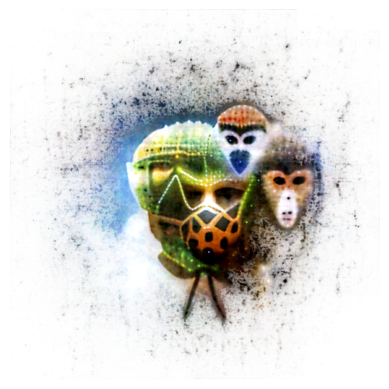

100%|██████████| 500/500 [00:04<00:00, 101.45it/s]


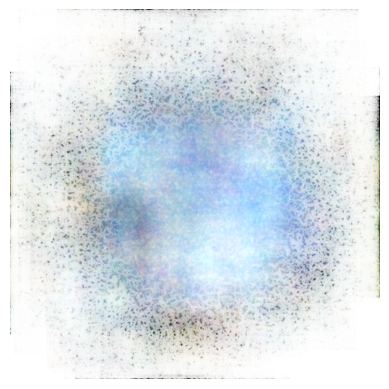

In [41]:
# Example of running MACO on regression model
model, _ = load_model_transform(modelname, device=device)
normalizer = T.Compose([
    T.Resize(size=(224, 224), antialias=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
fetcher.record(layer,  ingraph=True, store_device=device)
Xtransform = PCA_torch(Xtransform_layer, device=device)
# readout = LinearRegression_torch(SKLEARN_MODEL,)
# Define the prediction pipeline
def population_objective(images):
    # Forward pass through the feature extractor
    images = normalizer(images)
    model(images)
    feat_tsr = fetcher[layer]  # Access the layer4 feature
    feat_vec = Xtransform(feat_tsr)
    return readout(feat_vec).mean(dim=1).mean()

unit_idx = 0
def unit_objective(images):
    # Forward pass through the feature extractor
    model(images)
    feat_tsr = fetcher[layer]  # Access the layer4 feature
    feat_vec = Xtransform(feat_tsr)
    return readout(feat_vec)[:, unit_idx].mean()

# check_gradient(objective)
maco_hyperparams = dict(total_steps=500, learning_rate=0.5, image_size=512,
        model_input_size=224, noise=0.01, values_range=(0, 1),
        crops_per_iteration=2, box_size=(0.20, 0.25),)

image1, alpha1 = maco(population_objective, **maco_hyperparams, device='cuda')
plot_maco(image1, alpha1)
plt.show()

image1, alpha1 = maco(unit_objective, **maco_hyperparams, device='cuda')
plot_maco(image1, alpha1)
plt.show()

In [12]:
Xdict_prune = pkl.load(open(join(figdir, f"{subject_id}_{modelname}_population_best_layer_Xfeatures.pkl"), "rb"))
dimred = Xdict_prune["dimred"]
layer = Xdict_prune["layer"]
Xtransform = Xtfmer_pkl[(layer, dimred)]

In [13]:
Xtransform

PCA(n_components=750)